In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import scipy.stats as sps

**GENERATE DATA**

In [3]:
num_teams = 10
num_matches = num_teams*(num_teams-1)
num_venues = 5
num_players = num_teams*11 + 1

In [4]:
toss_won_by_team1_probability = sps.bernoulli(p=0.5)
toss_won_by_team1_outcomes_by_match = toss_won_by_team1_probability.rvs(num_matches)
toss_won_by_team1_outcomes_by_match

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1])

In [5]:
toss_winning_team_bowls_probability = sps.bernoulli(p=0.8)
toss_winning_team_bowls_outcomes = toss_winning_team_bowls_probability.rvs(num_matches)

In [6]:
teams = np.arange(0,num_teams)
team_combinations = np.array(np.meshgrid(teams,teams)).T.reshape(-1,2)
team_combinations_df = pd.DataFrame(team_combinations,
                                    columns = ['team1','team2'])
team_combinations_df = team_combinations_df.loc[team_combinations_df.team1!=team_combinations_df.team2].reset_index(drop=True)

In [7]:
def get_toss_winning_team(row):
    if row['toss_won_by_team1'] == 1:
        return row['team1']
    else:
        return row['team2']

def get_toss_losing_team(row):
    if row['toss_won_by_team1'] == 1:
        return row['team2']
    else:
        return row['team1']
    
def get_innings1_bowling_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_winning_team']
    else:
        return row['toss_losing_team']
    
def get_innings1_batting_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_losing_team']
    else:
        return row['toss_winning_team']
    
def get_innings2_bowling_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_losing_team']
    else:
        return row['toss_winning_team']
    
def get_innings2_batting_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_winning_team']
    else:
        return row['toss_losing_team']
    
matches_df = team_combinations_df.copy()
matches_df['match_key'] = np.arange(0,num_matches)
matches_df['toss_won_by_team1'] = toss_won_by_team1_outcomes_by_match
matches_df['toss_winning_team'] = matches_df.apply(get_toss_winning_team,
                                                   axis=1)
matches_df['toss_losing_team'] = matches_df.apply(get_toss_losing_team,
                                                   axis=1)
matches_df['toss_winning_team_bowls'] = toss_winning_team_bowls_outcomes
matches_df['innings1_batting_team'] = matches_df.apply(get_innings1_batting_team,
                                                       axis=1)
matches_df['innings1_bowling_team'] = matches_df.apply(get_innings1_bowling_team,
                                                       axis=1)
matches_df['innings2_batting_team'] = matches_df.apply(get_innings2_batting_team,
                                                       axis=1)
matches_df['innings2_bowling_team'] = matches_df.apply(get_innings2_bowling_team,
                                                       axis=1)

In [8]:
matches_df

,team1,team2,match_key,toss_won_by_team1,toss_winning_team,toss_losing_team,toss_winning_team_bowls,innings1_batting_team,innings1_bowling_team,innings2_batting_team,innings2_bowling_team
0,0,1,0,1,0,1,0,0,1,1,0
1,0,2,1,1,0,2,0,0,2,2,0
2,0,3,2,0,3,0,1,0,3,3,0
3,0,4,3,0,4,0,0,4,0,0,4
4,0,5,4,0,5,0,1,0,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...
85,9,4,85,1,9,4,1,4,9,9,4
86,9,5,86,1,9,5,1,5,9,9,5
87,9,6,87,1,9,6,1,6,9,9,6
88,9,7,88,0,7,9,1,9,7,7,9


In [9]:
players_by_team = np.array([[f'team{team_id}_player{player_id}'
                    for player_id in range(12)]
                   for team_id in range(num_teams)])

In [10]:
players_by_team.shape

(10, 12)

In [11]:
player_id_index, player_id = pd.Series(players_by_team.ravel()).factorize()

In [12]:
player2idx = pd.DataFrame({'player_id':player_id_index},index=player_id)

In [13]:
player2idx.loc['team0_player1']['player_id']

1

In [14]:
p_player_bowls_over = np.array([sps.dirichlet.rvs(np.ones(players_by_team.shape[1]),size=21).T 
                                for team in range(num_teams)])

In [15]:
p_player_bowls_over.shape

(10, 12, 21)

In [16]:
p_player_bowls_over[0,:,12].sum()

0.9999999999999998

In [17]:
p_batsman_at_position = np.array([sps.dirichlet.rvs(np.ones(players_by_team.shape[1]),size=11) 
                                for team in range(num_teams)])

In [18]:
p_batsman_at_position[0,0,:].sum()

1.0

In [19]:
bowling_outcomes_index = pd.DataFrame({
    'bowling_outcomes_index': ['0', '1-b', '1-oe', '1-nb', '1-w', '2-b', '2-oe', '2-nb', '2-w','3-b', '3-oe', '3-nb', '3-w','4-b', '4-oe', '4-nb', '4-w','5-b', '5-oe', '5-nb', '5-w', '6-b', '6-oe', '6-nb', '6-w', 'W-b', 'W-bc','W-bs','W-dro',
                                                'W-idro','W-others'],
    'runs_scored': [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,0,0,0,0,0,0],
    'batter_switched': [1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0],
    'is_legal': [1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,1,1,1]
})

In [20]:
bowling_outcomes_index

,bowling_outcomes_index,runs_scored,batter_switched,is_legal
0,0,0,1,1
1,1-b,1,1,1
2,1-oe,1,1,1
3,1-nb,1,0,0
4,1-w,1,0,0
5,2-b,2,0,1
6,2-oe,2,0,1
7,2-nb,2,1,0
8,2-w,2,1,0
9,3-b,3,1,1


In [21]:
bowling_outcomes_index['alpha_for_bowling_outcome_index']= sps.norm(0,1).rvs(size=bowling_outcomes_index.shape[0])

In [22]:
beta_by_player_and_bowling_outcome = np.array([[sps.norm(0,1).rvs(size=bowling_outcomes_index.shape[0]) 
                                      for player in range(12)]
                                      for team in range(num_teams)])

In [23]:
beta_by_player_and_bowling_outcome.shape

(10, 12, 31)

In [149]:
bowling_outcomes_index

,bowling_outcomes_index,runs_scored,batter_switched,is_legal,alpha_for_bowling_outcome_index
0,0,0,1,1,0.607370
1,1-b,1,1,1,-1.637670
2,1-oe,1,1,1,-1.444523
3,1-nb,1,0,0,1.813572
4,1-w,1,0,0,-0.616769
5,2-b,2,0,1,-0.568139
6,2-oe,2,0,1,0.374056
7,2-nb,2,1,0,1.674436
8,2-w,2,1,0,-0.222699
9,3-b,3,1,1,0.585534


In [24]:
from scipy.special import softmax

In [25]:
from collections import Counter
bowling_outcome_by_ball_and_innings_list = []
match_state_by_ball_and_innings_list = []
match_stats_list = []

for match_key, match_df in matches_df.groupby('match_key'):
    match_stats = {}
    for innings in range(2):
        bowler_overs_bowled = Counter()
        total_balls_bowled = 0
        wickets_lost = 0
        current_score = 0
        batters_dismissed = set()
        bowling_team_id = match_df[f'innings{innings+1}_bowling_team'].iloc[0]
        batting_team_id = match_df[f'innings{innings+1}_batting_team'].iloc[0]
        onstrike_batter_rv = sps.multinomial(1,p_batsman_at_position[batting_team_id,0,:]).rvs(1)[0]
        onstrike_batter_id = np.where(onstrike_batter_rv==1)[0][0]
        offstrike_batter_id = onstrike_batter_id
        while offstrike_batter_id == onstrike_batter_id:
            offstrike_batter_rv = sps.multinomial(1,p_batsman_at_position[batting_team_id,1,:]).rvs(1)[0]
            offstrike_batter_id = np.where(offstrike_batter_rv==1)[0][0]
        onstrike_batter_name = f"team{batting_team_id}_player{onstrike_batter_id}"
        onstrike_batter_player_idx = player2idx.loc[onstrike_batter_name]['player_id']
        offstrike_batter_name = f"team{batting_team_id}_player{offstrike_batter_id}"
        offstrike_batter_player_idx = player2idx.loc[offstrike_batter_name]['player_id']
        for over in range(20):
            selected_bowler_has_overs = False
            while not(selected_bowler_has_overs):
                selected_bowler_rv = sps.multinomial(1,p_player_bowls_over[bowling_team_id,:,over]).rvs(1)[0]
                selected_bowler_id = np.where(selected_bowler_rv==1)[0][0]
                selected_bowler_name = f"team{bowling_team_id}_player{selected_bowler_id}"
                selected_bowler_player_idx = player2idx.loc[selected_bowler_name]['player_id']
                if bowler_overs_bowled[selected_bowler_id] < 4:
                    selected_bowler_has_overs = True
            legal_balls_bowled_in_over = 0
            total_balls_bowled_in_over = 0
            while legal_balls_bowled_in_over<6:
                if innings == 0:
                    runs_to_target = -1
                else:
                    runs_to_target = target - current_score
                ball_number_in_over = min(6,total_balls_bowled_in_over)
                match_state_row = {
                    'match_key': match_key,
                    'innings': innings,
                    'over_number': over,
                    'ball_number_in_over': ball_number_in_over,
                    'bowler_id': selected_bowler_player_idx,
                    'batter_id': onstrike_batter_player_idx,
                    'current_score': current_score,
                    'batting_team_id': batting_team_id,
                    'bowling_team_id': bowling_team_id,
                    'wickets_fallen': wickets_lost,
                    'total_balls_bowled': total_balls_bowled,
                    'runs_to_target': runs_to_target
                }
                total_balls_bowled_in_over+=1
                total_balls_bowled +=1
                ball_outcome_mu = bowling_outcomes_index['alpha_for_bowling_outcome_index'].values + beta_by_player_and_bowling_outcome[batting_team_id,onstrike_batter_id,:]
                ball_outcome_p = softmax(ball_outcome_mu)
                ball_outcome_rv = sps.multinomial(1,ball_outcome_p).rvs(1)
                ball_outcome = np.where(ball_outcome_rv==1)[1][0]
                current_score += bowling_outcomes_index.iloc[ball_outcome]['runs_scored']
                bowling_outcomes_row = {
                    'match_key': match_key,
                    'innings': innings,
                    'over_number': over,
                    'ball_number_in_over': ball_number_in_over,
                    'bowling_outcome_index': ball_outcome,
                    'bowler_id': selected_bowler_name
                }
                match_state_by_ball_and_innings_list.append(match_state_row)
                bowling_outcome_by_ball_and_innings_list.append(bowling_outcomes_row)
                if innings == 1 and current_score >= target:
                    break
                if bowling_outcomes_index.iloc[ball_outcome]['is_legal'] == 1:
                    legal_balls_bowled_in_over+=1
                if ball_outcome >= 25:
                    #wicket has fallen, find new batsman
                    wickets_lost += 1
                    if wickets_lost == 10:
                        break
                    next_at_bat = wickets_lost + 1
                    batters_dismissed.add(onstrike_batter_id)
                    while onstrike_batter_id in batters_dismissed:
                        onstrike_batter_rv = sps.multinomial(1,p_batsman_at_position[batting_team_id,next_at_bat,:]).rvs(1)[0]
                        onstrike_batter_id = np.where(onstrike_batter_rv==1)[0][0]
                        onstrike_batter_name = f"team{batting_team_id}_player{onstrike_batter_id}"
                        onstrike_batter_player_idx = player2idx.loc[onstrike_batter_name]['player_id']
                if bowling_outcomes_index.iloc[ball_outcome]['batter_switched'] == 1:
                    temp = onstrike_batter_id
                    onstrike_batter_id = offstrike_batter_id
                    offstrike_batter_id = temp
                    temp = onstrike_batter_name
                    onstrike_batter_name = offstrike_batter_name
                    offstrike_batter_name = temp
                    temp = onstrike_batter_player_idx
                    onstrike_batter_player_idx = offstrike_batter_player_idx
                    offstrike_batter_player_idx = temp
            bowler_overs_bowled[selected_bowler_id]+=1
            if wickets_lost == 10 or (innings == 1 and current_score >= target):
                break
        if innings == 0:
            target = current_score + 1
        match_stats[innings] = {'score': current_score, 'wickets_lost': wickets_lost}
    if match_stats[0]['score']>match_stats[1]['score']:
        match_stats['winner'] = match_df['innings1_batting_team'].iloc[0]
    elif match_stats[0]['score'] == match_stats[1]['score']:
        match_stats_winner = 'draw'
    else:
        match_stats['winner'] = match_df['innings2_batting_team'].iloc[0]
    match_stats_list.append(match_stats)
        

In [26]:
match_state_by_ball_and_innings_df = pd.DataFrame(match_state_by_ball_and_innings_list)

In [27]:
match_state_by_ball_and_innings_df.loc[match_state_by_ball_and_innings_df.wickets_fallen>0]

,match_key,innings,over_number,ball_number_in_over,bowler_id,batter_id,current_score,batting_team_id,bowling_team_id,wickets_fallen,total_balls_bowled,runs_to_target
14,0,0,1,1,22,4,42,0,1,1,14,-1
15,0,0,1,2,22,7,48,0,1,1,15,-1
16,0,0,1,3,22,4,50,0,1,1,16,-1
17,0,0,1,4,22,4,55,0,1,1,17,-1
18,0,0,1,5,22,7,60,0,1,1,18,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
16551,89,1,12,6,102,113,611,9,8,7,160,21
16552,89,1,13,0,99,113,615,9,8,7,161,17
16553,89,1,13,1,99,113,621,9,8,7,162,11
16554,89,1,13,2,99,113,626,9,8,7,163,6


In [28]:
bowling_outcomes_by_ball_and_innings_df = pd.DataFrame(bowling_outcome_by_ball_and_innings_list)

In [29]:
bowling_outcomes_by_ball_and_innings_df.bowling_outcome_index.value_counts()

19    1849
3     1500
24    1408
7     1240
10    1054
17     933
15     789
13     729
22     703
29     684
14     634
0      513
9      479
18     448
23     437
12     430
20     398
6      354
25     320
28     229
8      226
5      187
27     166
4      158
21     136
11     135
16     125
26      90
30      82
2       62
1       58
Name: bowling_outcome_index, dtype: int64

In [203]:
train_idx = 10000

In [204]:
COORDS = {
    'player_id': player_id,
    'bowling_outcomes': bowling_outcomes_index.bowling_outcomes_index,
    'balls': bowling_outcomes_by_ball_and_innings_df.index[:train_idx]
}

In [31]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
batter_encoded_array = encoder.fit_transform(match_state_by_ball_and_innings_df[['batter_id']])

outcome_encoder = OneHotEncoder(handle_unknown='ignore')
outcome_encoded_array = outcome_encoder.fit_transform(bowling_outcomes_by_ball_and_innings_df[['bowling_outcome_index']])

In [32]:
outcome_encoded_array.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
import aesara.tensor as at

In [34]:
player2idx.shape

(120, 1)

In [35]:
with pm.Model(coords = COORDS) as mn_bowling_outcomes_model_by_ball_first_innings:
  batter_id_by_ball_and_innings_data = pm.MutableData('batter_id_by_ball_and_innings_data',
                                                      batter_encoded_array)
  bowling_outcomes_by_ball_and_innings_data = pm.MutableData('bowling_outcomes_by_ball_and_innings_data',
                                                             outcome_encoded_array.A)
  player_id_idx_ = pm.ConstantData('player_id_idx',
                                   player_id_index)
  bowling_outcomes_idx_ = pm.ConstantData('bowling_outcomes_idx',
                                          bowling_outcomes_index.index)
  alpha_bowling_outcome = pm.Normal('alpha_bowling_outcome', 
                                    mu=0, 
                                    sigma=1, 
                                    shape=bowling_outcomes_index.shape[0])
  beta_for_batter_id_and_bowling_outcome = pm.Normal('beta_for_batter_id_and_bowling_outcome', 
                                                     mu=0, 
                                                     sigma=1, 
                                                     dims = ('player_id','bowling_outcomes'),
                                                     initval=beta_by_player_and_bowling_outcome.reshape(120,31))
  mu_bowling_outcomes = pm.Deterministic('mu_bowling_outcomes',
                                        at.dot(batter_id_by_ball_and_innings_data,
                                               beta_for_batter_id_and_bowling_outcome) + alpha_bowling_outcome)
  probability_of_bowling_outcome = pm.Deterministic('probability_of_bowling_outcome',
                                                    mu_bowling_outcomes - at.logsumexp(mu_bowling_outcomes,
                                                                                       axis=1,
                                                                                       keepdims=True))
  bowling_outcomes_by_ball_and_innings_rv = pm.Multinomial('bowling_outcomes_by_ball_and_innings_rv', 
                                                           n = 1,
                                                           p = probability_of_bowling_outcome,
                                                           observed = bowling_outcomes_by_ball_and_innings_data,
                                                           initval = 'prior')


In [ ]:
with mn_bowling_outcomes_model_by_ball_first_innings:
    idata = pm.sample(random_seed=RANDOM_SEED)

In [36]:
RANDOM_SEED = 8265

In [37]:
batter_encoded_array[:10000]

<10000x120 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>

In [243]:
with pm.Model(coords = COORDS) as cat_bowling_outcomes_model_by_ball_first_innings:
  batter_id_by_ball_and_innings_data = pm.MutableData('batter_id_by_ball_and_innings_data',
                                                      batter_encoded_array[:train_idx])
  bowling_outcomes_by_ball_and_innings_data = pm.MutableData('bowling_outcomes_by_ball_and_innings_data',
                                                             bowling_outcomes_by_ball_and_innings_df['bowling_outcome_index'].values[:train_idx])
  alpha_bowling_outcome_rv = pm.Normal('alpha_bowling_outcome', 
                                    mu=0, 
                                    sigma=1, 
                                    dims = ('bowling_outcomes'))
  beta_for_batter_id_and_bowling_outcome_rv = pm.Normal('beta_for_batter_id_and_bowling_outcome', 
                                                     mu=0, 
                                                     sigma=1, 
                                                     dims = ('player_id','bowling_outcomes'))
  mu_bowling_outcomes = pm.Deterministic('mu_bowling_outcomes',
                                        at.dot(batter_id_by_ball_and_innings_data,
                                               beta_for_batter_id_and_bowling_outcome_rv) + alpha_bowling_outcome_rv)
  probability_of_bowling_outcome = pm.Deterministic('probability_of_bowling_outcome',
                                                    at.nnet.softmax(mu_bowling_outcomes))
  bowling_outcomes_by_ball_and_innings_rv = pm.Categorical('bowling_outcomes_by_ball_and_innings_rv', 
                                                           p = probability_of_bowling_outcome,
                                                           observed = bowling_outcomes_by_ball_and_innings_data,
                                                           shape = batter_id_by_ball_and_innings_data.shape[0])

In [ ]:
with cat_bowling_outcomes_model_by_ball_first_innings:
    idata = pm.sample(random_seed=RANDOM_SEED,
                      chains = 2,
                      target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_bowling_outcome, beta_for_batter_id_and_bowling_outcome]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3256 seconds.


In [41]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [48]:
idata.posterior.coords

Coordinates:
  * chain                                 (chain) int64 0 1 2 3
  * draw                                  (draw) int64 0 1 2 3 4 ... 96 97 98 99
  * alpha_bowling_outcome_dim_0           (alpha_bowling_outcome_dim_0) int64 ...
  * player_id                             (player_id) <U14 'team0_player0' .....
  * bowling_outcomes                      (bowling_outcomes) <U8 '0' ... 'W-o...
  * mu_bowling_outcomes_dim_0             (mu_bowling_outcomes_dim_0) int64 0...
  * mu_bowling_outcomes_dim_1             (mu_bowling_outcomes_dim_1) int64 0...
  * probability_of_bowling_outcome_dim_0  (probability_of_bowling_outcome_dim_0) int64 ...
  * probability_of_bowling_outcome_dim_1  (probability_of_bowling_outcome_dim_1) int64 ...

array([[<AxesSubplot: title={'center': 'alpha_bowling_outcome'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome'}>]],
      dtype=object)

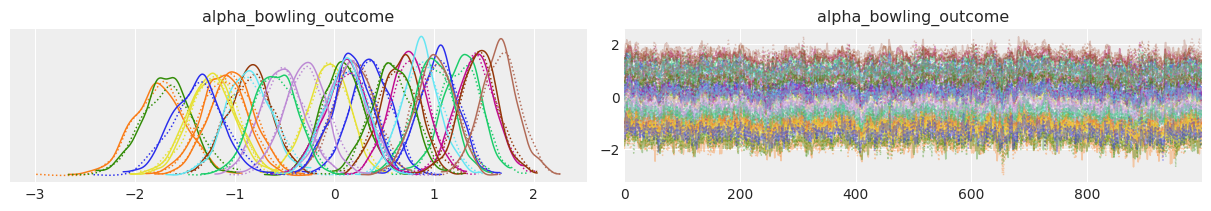

In [42]:
az.plot_trace(idata.posterior.alpha_bowling_outcome)

In [43]:
with cat_bowling_outcomes_model_by_ball_first_innings:
    idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata.extend(pm.sample_posterior_predictive(idata,random_seed=RANDOM_SEED))

Sampling: [alpha_bowling_outcome, beta_for_batter_id_and_bowling_outcome, bowling_outcomes_by_ball_and_innings_rv]
Sampling: [bowling_outcomes_by_ball_and_innings_rv]


<AxesSubplot: xlabel='bowling_outcomes_by_ball_and_innings_rv / bowling_outcomes_by_ball_and_innings_rv'>

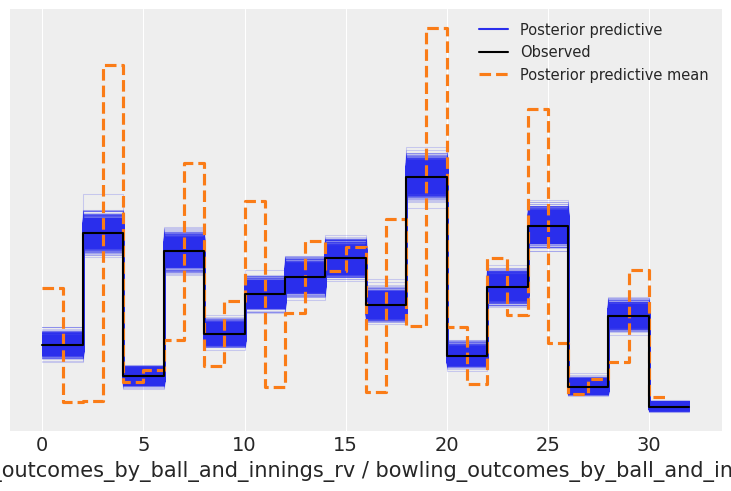

In [44]:
az.plot_ppc(idata)

In [46]:
idata.log_likelihood

<xarray.Dataset>
Dimensions:                                        (chain: 2, draw: 1000,
                                                    bowling_outcomes_by_ball_and_innings_rv_dim_0: 1,
                                                    bowling_outcomes_by_ball_and_innings_rv_dim_1: 10000)
Coordinates:
  * chain                                          (chain) int64 0 1
  * draw                                           (draw) int64 0 1 ... 998 999
  * bowling_outcomes_by_ball_and_innings_rv_dim_0  (bowling_outcomes_by_ball_and_innings_rv_dim_0) int64 ...
  * bowling_outcomes_by_ball_and_innings_rv_dim_1  (bowling_outcomes_by_ball_and_innings_rv_dim_1) int64 ...
Data variables:
    bowling_outcomes_by_ball_and_innings_rv        (chain, draw, bowling_outcomes_by_ball_and_innings_rv_dim_0, bowling_outcomes_by_ball_and_innings_rv_dim_1) float64 ...
Attributes:
    created_at:                 2022-11-01T11:52:33.818656
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2

<AxesSubplot: >

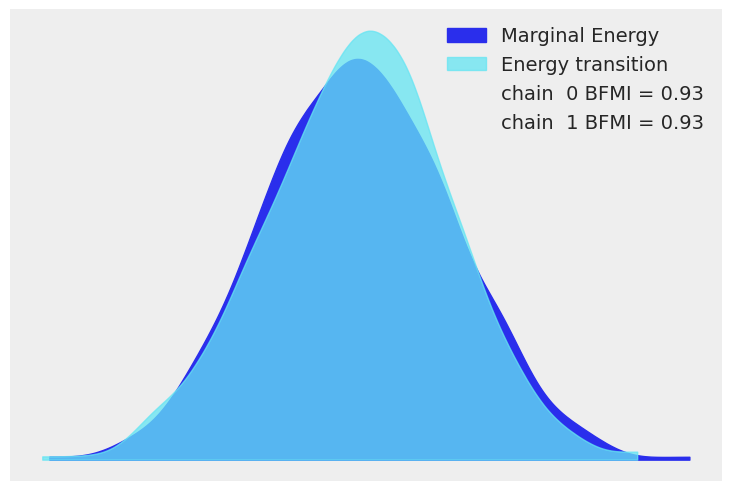

In [45]:
az.plot_energy(idata)

In [139]:
with cat_bowling_outcomes_model_by_ball_first_innings:
    pm.set_data({
        'batter_id_by_ball_and_innings_data': batter_encoded_array[5000:10000]
    })
    idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
    )

Sampling: [bowling_outcomes_by_ball_and_innings_rv]


In [145]:
idata.posterior

<xarray.Dataset>
Dimensions:                                 (chain: 2, draw: 1000,
                                             alpha_bowling_outcome_dim_0: 31,
                                             player_id: 120,
                                             bowling_outcomes: 31,
                                             mu_bowling_outcomes_dim_0: 5000,
                                             mu_bowling_outcomes_dim_1: 31,
                                             probability_of_bowling_outcome_dim_0: 5000,
                                             probability_of_bowling_outcome_dim_1: 31)
Coordinates:
  * chain                                   (chain) int64 0 1
  * draw                                    (draw) int64 0 1 2 3 ... 997 998 999
  * alpha_bowling_outcome_dim_0             (alpha_bowling_outcome_dim_0) int64 ...
  * player_id                               (player_id) <U14 'team0_player0' ...
  * bowling_outcomes                        (bowling_outcomes) <U8 '0' ... 'W...
  * mu_bowling_outcomes_dim_0               (mu_bowling_outcomes_dim_0) int64 ...
  * mu_bowling_outcomes_dim_1               (mu_bowling_outcomes_dim_1) int64 ...
  * probability_of_bowling_outcome_dim_0    (probability_of_bowling_outcome_dim_0) int64 ...
  * probability_of_bowling_outcome_dim_1    (probability_of_bowling_outcome_dim_1) int64 ...
Data variables:
    alpha_bowling_outcome                   (chain, draw, alpha_bowling_outcome_dim_0) float64 ...
    beta_for_batter_id_and_bowling_outcome  (chain, draw, player_id, bowling_outcomes) float64 ...
    mu_bowling_outcomes                     (chain, draw, mu_bowling_outcomes_dim_0, mu_bowling_outcomes_dim_1) float64 ...
    probability_of_bowling_outcome          (chain, draw, probability_of_bowling_outcome_dim_0, probability_of_bowling_outcome_dim_1) float64 ...
Attributes:
    created_at:                 2022-11-02T00:29:51.590703
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              453.7547342777252
    tuning_steps:               1000

In [141]:
idata.predictions

<xarray.Dataset>
Dimensions:                                        (chain: 2, draw: 1000,
                                                    bowling_outcomes_by_ball_and_innings_rv_dim_0: 5000)
Coordinates:
  * chain                                          (chain) int64 0 1
  * draw                                           (draw) int64 0 1 ... 998 999
  * bowling_outcomes_by_ball_and_innings_rv_dim_0  (bowling_outcomes_by_ball_and_innings_rv_dim_0) int64 ...
Data variables:
    bowling_outcomes_by_ball_and_innings_rv        (chain, draw, bowling_outcomes_by_ball_and_innings_rv_dim_0) int64 ...
Attributes:
    created_at:                 2022-11-02T00:30:57.530320
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2

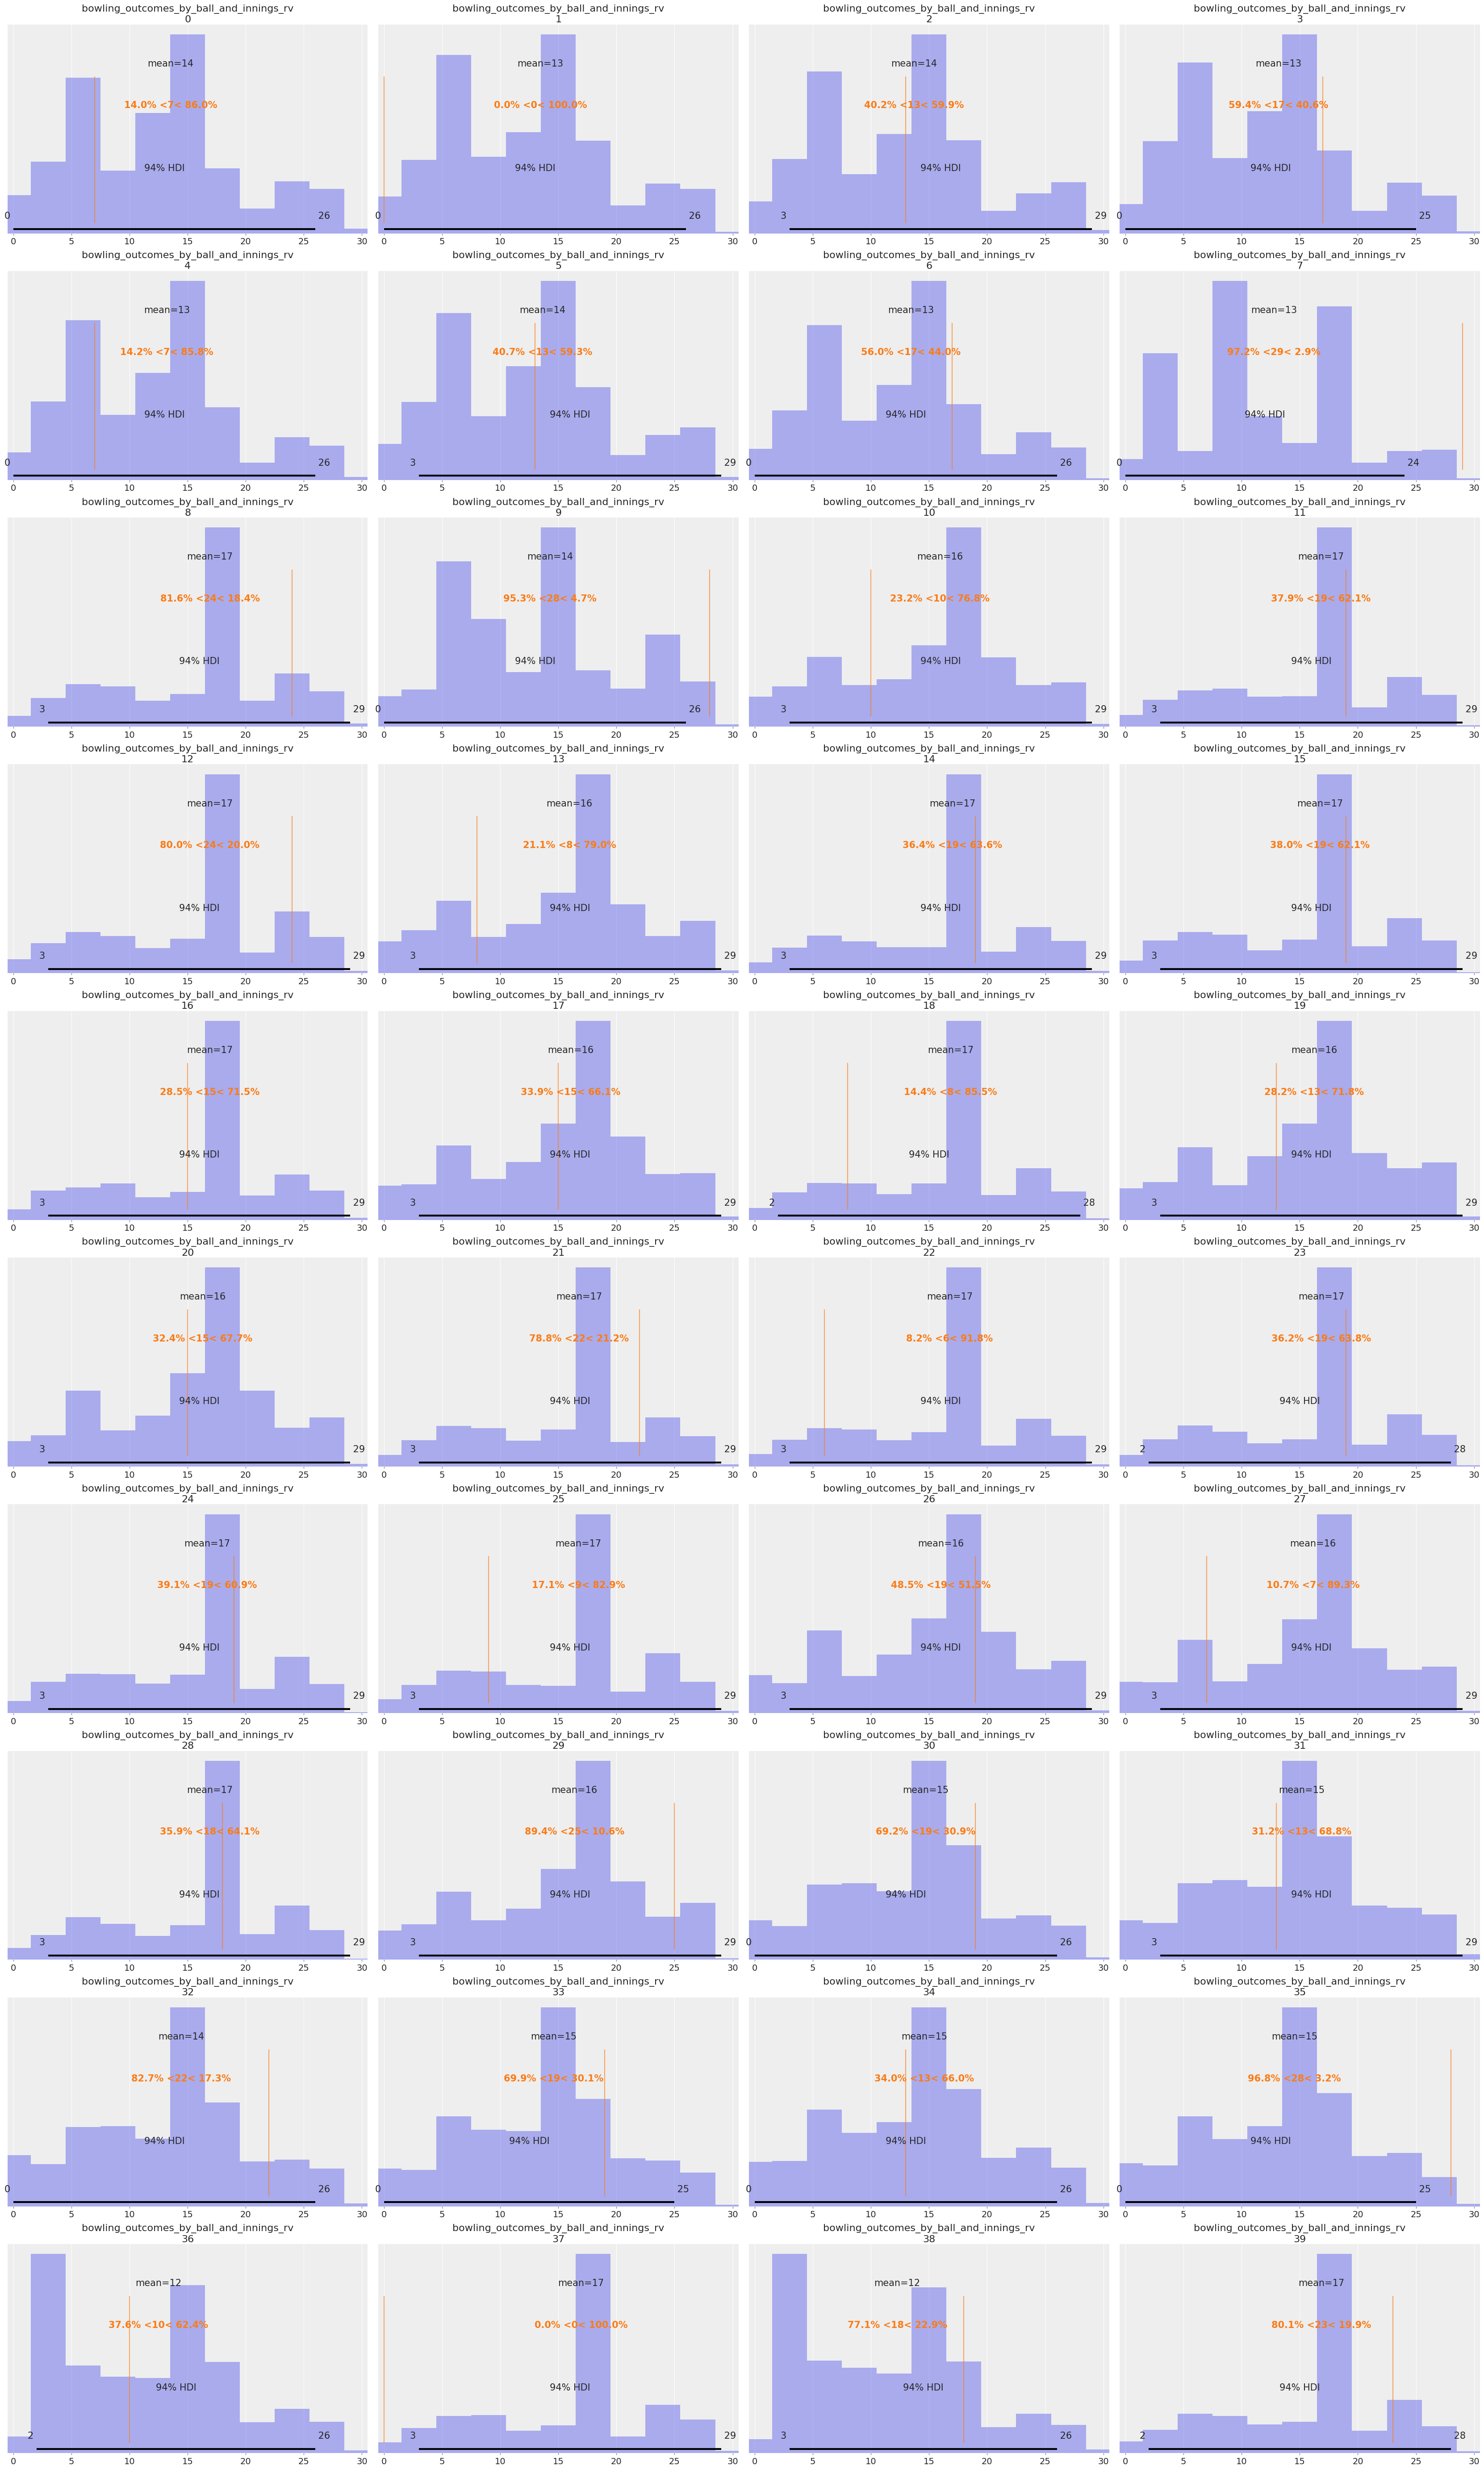

In [143]:
az.plot_posterior(
    idata.predictions,
    ref_val=bowling_outcomes_by_ball_and_innings_df['bowling_outcome_index'].values[5000:10000].tolist(),
);

(array([ 436916., 1028982.,  974195., 1021267., 1125399., 1198413.,
        1486465.,  753462., 1178385.,  796516.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

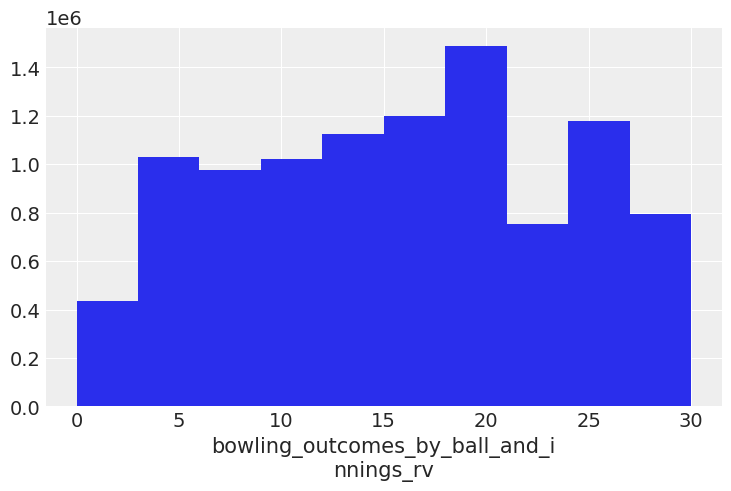

In [216]:
idata.predictions.bowling_outcomes_by_ball_and_innings_rv.plot()

In [219]:
stacks = az.extract(idata.predictions)

In [220]:
stacks

<xarray.Dataset>
Dimensions:                                        (
                                                    bowling_outcomes_by_ball_and_innings_rv_dim_0: 5000,
                                                    sample: 2000)
Coordinates:
  * bowling_outcomes_by_ball_and_innings_rv_dim_0  (bowling_outcomes_by_ball_and_innings_rv_dim_0) int64 ...
  * sample                                         (sample) object MultiIndex
  * chain                                          (sample) int64 0 0 0 ... 1 1
  * draw                                           (sample) int64 0 1 ... 999
Data variables:
    bowling_outcomes_by_ball_and_innings_rv        (bowling_outcomes_by_ball_and_innings_rv_dim_0, sample) int64 ...
Attributes:
    created_at:                 2022-11-02T00:30:57.530320
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2

In [224]:
stacks.bowling_outcomes_by_ball_and_innings_rv[:,0]

<xarray.DataArray 'bowling_outcomes_by_ball_and_innings_rv' (
                                                             bowling_outcomes_by_ball_and_innings_rv_dim_0: 5000)>
array([ 3, 17,  7, ..., 25, 10, 12])
Coordinates:
  * bowling_outcomes_by_ball_and_innings_rv_dim_0  (bowling_outcomes_by_ball_and_innings_rv_dim_0) int64 ...
    sample                                         object (0, 0)
    chain                                          int64 0
    draw                                           int64 0

In [240]:
from sklearn.metrics import f1_score
f1_score(bowling_outcomes_by_ball_and_innings_df['bowling_outcome_index'].values[5000:10000], 
         stacks.bowling_outcomes_by_ball_and_innings_rv[:,-1],
         average = None)

array([0.08, 0.  , 0.  , 0.11, 0.  , 0.04, 0.06, 0.11, 0.04, 0.09, 0.12,
       0.  , 0.04, 0.04, 0.09, 0.08, 0.  , 0.07, 0.04, 0.16, 0.05, 0.  ,
       0.07, 0.03, 0.11, 0.05, 0.04, 0.02, 0.05, 0.08, 0.  ])

In [232]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(bowling_outcomes_by_ball_and_innings_df['bowling_outcome_index'].values[5000:10000],
                      stacks.bowling_outcomes_by_ball_and_innings_rv[:,-1])

In [236]:
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,14,0,2,12,1,1,3,6,0,5,...,0,13,7,12,6,2,1,2,3,1
1,1,0,0,1,0,0,3,2,0,3,...,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1,1,1,...,0,1,0,3,1,0,0,0,0,0
3,19,2,4,44,2,2,10,24,4,15,...,0,15,13,32,13,4,8,5,20,2
4,2,0,0,3,0,1,1,1,1,0,...,0,3,1,7,3,0,0,0,5,0
5,2,0,0,4,0,2,0,5,1,3,...,1,5,6,4,0,0,0,1,3,0
6,1,0,2,7,3,0,6,6,1,6,...,0,6,3,8,2,1,0,3,8,2
7,18,2,3,22,0,2,2,36,4,13,...,5,11,13,32,8,2,7,6,15,5
8,2,0,1,6,1,0,3,8,3,1,...,0,2,0,9,1,0,2,0,1,0
9,0,0,3,10,0,1,3,4,2,15,...,0,5,1,15,2,2,3,4,10,1


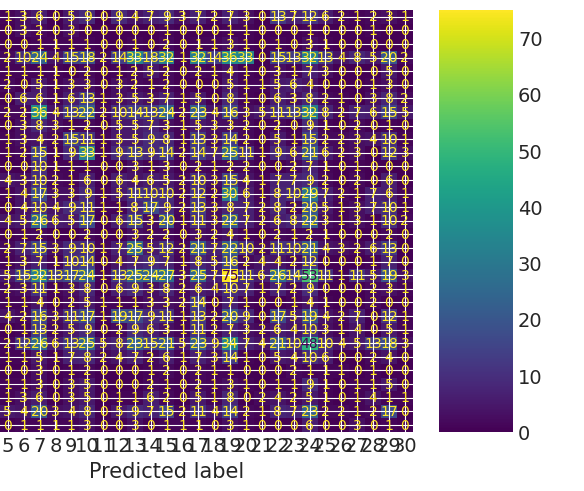

In [233]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [150]:
bowling_outcomes_index

,bowling_outcomes_index,runs_scored,batter_switched,is_legal,alpha_for_bowling_outcome_index
0,0,0,1,1,0.607370
1,1-b,1,1,1,-1.637670
2,1-oe,1,1,1,-1.444523
3,1-nb,1,0,0,1.813572
4,1-w,1,0,0,-0.616769
5,2-b,2,0,1,-0.568139
6,2-oe,2,0,1,0.374056
7,2-nb,2,1,0,1.674436
8,2-w,2,1,0,-0.222699
9,3-b,3,1,1,0.585534


In [152]:
bowling_outcomes_index[['alpha_for_bowling_outcome_index']].to_dict(orient='records')

[{'alpha_for_bowling_outcome_index': 0.6073702286511468},
 {'alpha_for_bowling_outcome_index': -1.6376702704302475},
 {'alpha_for_bowling_outcome_index': -1.4445227410044477},
 {'alpha_for_bowling_outcome_index': 1.8135724238750146},
 {'alpha_for_bowling_outcome_index': -0.6167685745642069},
 {'alpha_for_bowling_outcome_index': -0.5681392568334297},
 {'alpha_for_bowling_outcome_index': 0.37405591227661866},
 {'alpha_for_bowling_outcome_index': 1.674435698623259},
 {'alpha_for_bowling_outcome_index': -0.22269891611204537},
 {'alpha_for_bowling_outcome_index': 0.5855337918399984},
 {'alpha_for_bowling_outcome_index': 1.5266857835562344},
 {'alpha_for_bowling_outcome_index': -0.6891538126059522},
 {'alpha_for_bowling_outcome_index': 0.33712518192045265},
 {'alpha_for_bowling_outcome_index': 1.1763299326058418},
 {'alpha_for_bowling_outcome_index': 0.814012827694379},
 {'alpha_for_bowling_outcome_index': 0.8992975752246501},
 {'alpha_for_bowling_outcome_index': -0.701572304785503},
 {'alph

array([[<AxesSubplot: title={'center': 'alpha_bowling_outcome\n0'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n1'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n2'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n3'}>],
       [<AxesSubplot: title={'center': 'alpha_bowling_outcome\n4'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n5'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n6'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n7'}>],
       [<AxesSubplot: title={'center': 'alpha_bowling_outcome\n8'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n9'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n10'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n11'}>],
       [<AxesSubplot: title={'center': 'alpha_bowling_outcome\n12'}>,
        <AxesSubplot: title={'center': 'alpha_bowling_outcome\n13'}>,
        <AxesSubplot: title

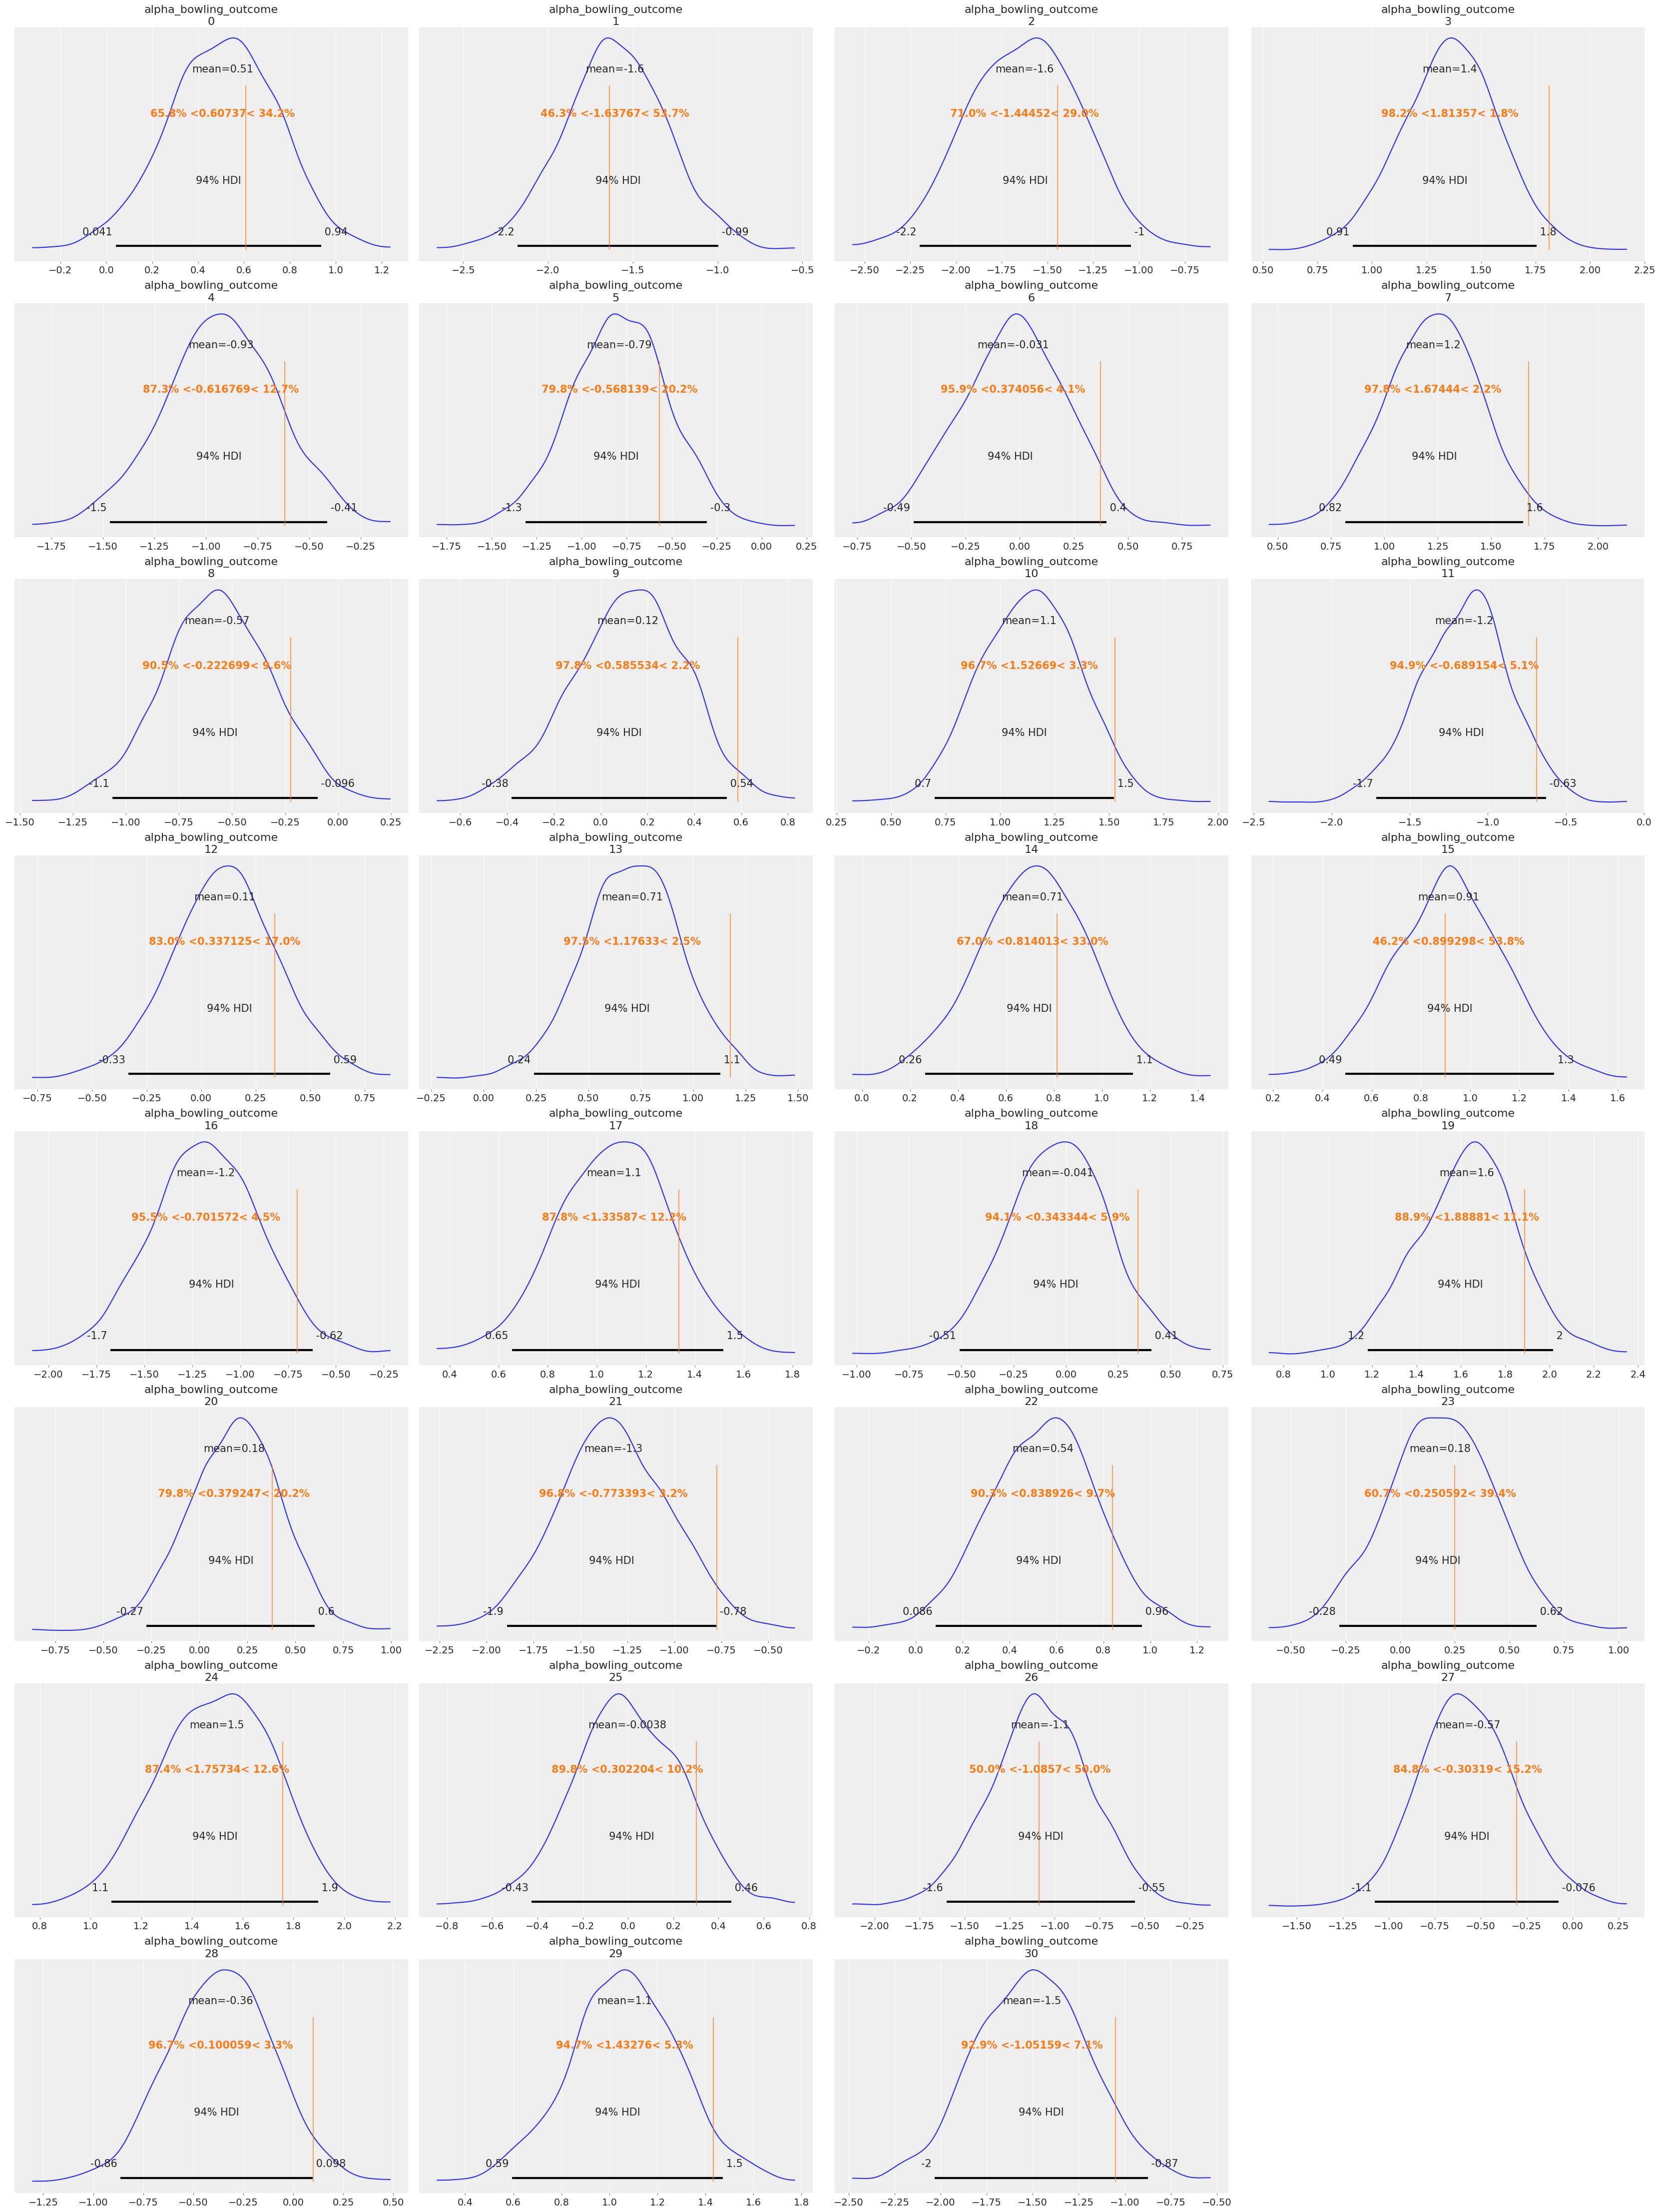

In [161]:
az.plot_posterior(
    idata.posterior['alpha_bowling_outcome'],
    ref_val = bowling_outcomes_index.alpha_for_bowling_outcome_index.values.tolist()
)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

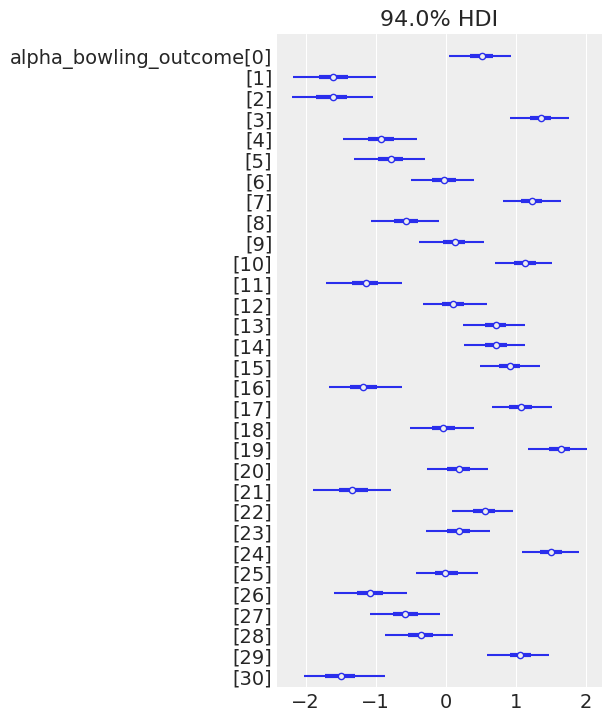

In [188]:
az.plot_forest(
    idata.posterior,
    var_names = ['alpha_bowling_outcome'],
    combined = True
)

In [202]:
bowling_outcomes

NameError: name 'bowling_outcomes' is not defined

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

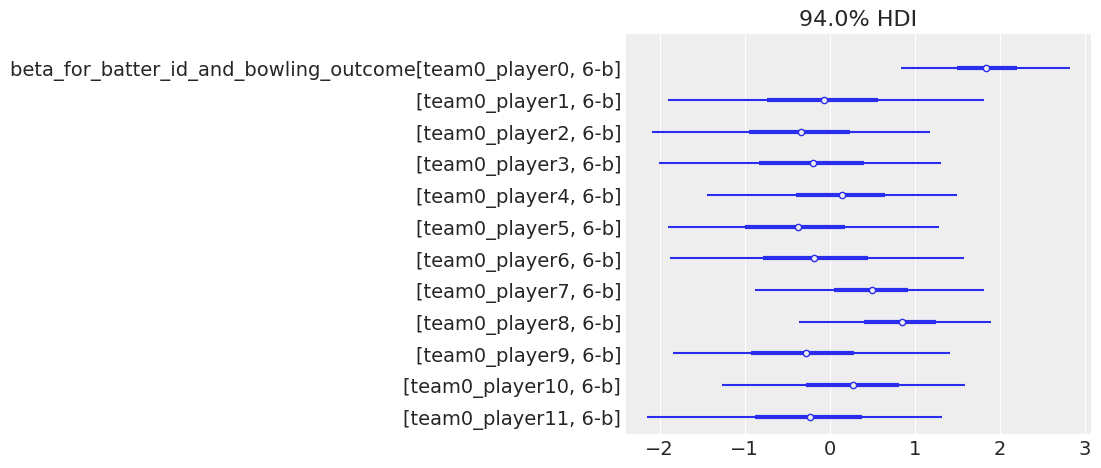

In [201]:
az.plot_forest(
    idata.posterior,
    var_names = ['beta_for_batter_id_and_bowling_outcome'],
    combined = True,
    coords = {'bowling_outcomes':['6-b'],
              'player_id': player_id[:12]}
)

In [49]:
batter_encoded_array[10000:].shape

(6556, 120)

In [174]:
full_sample_size = 200
num_batters = 120
num_outcomes = 31
p_batter = sps.dirichlet.rvs(np.ones(num_batters),size=1)[0]
batter_rv = sps.multinomial(1,p_batter).rvs(full_sample_size)
alpha_rv = sps.norm(0,1).rvs(size=num_outcomes)
beta_rv = np.array([sps.norm(0,1).rvs(size=num_outcomes) 
                                      for player in range(num_batters)])
mu_rv = alpha_rv + np.dot(batter_rv,beta_rv)
bowling_outcomes_p_rv = softmax(mu_rv,axis=0) 
bowling_outcome_encoded_rv = np.array([sps.multinomial(1,bowling_outcomes_p_rv[i]).rvs(1)[0] for i in range(full_sample_size)])
bowling_outcome_rv = np.where(bowling_outcome_encoded_rv==1)[1]


In [175]:
mu_rv.shape

(200, 31)

In [176]:
bowling_outcome_rv.shape

(200,)

In [180]:
train_idx = 130

with pm.Model() as model:
  batter_id_by_ball_and_innings_data = pm.MutableData('batter_id_by_ball_and_innings_data',
                                                      batter_rv[:train_idx])
  bowling_outcomes_by_ball_and_innings_data = pm.MutableData('bowling_outcomes_by_ball_and_innings_data',
                                                             bowling_outcome_rv[:train_idx])
  alpha_bowling_outcome_rv = pm.Normal('alpha_bowling_outcome', 
                                    mu=0, 
                                    sigma=1, 
                                    shape=bowling_outcomes_index.shape[0])
  beta_for_batter_id_and_bowling_outcome_rv = pm.Normal('beta_for_batter_id_and_bowling_outcome', 
                                                     mu=0, 
                                                     sigma=1, 
                                                     shape = (num_batters,num_outcomes))
  mu_bowling_outcomes = pm.Deterministic('mu_bowling_outcomes',
                                        at.dot(batter_id_by_ball_and_innings_data,
                                               beta_for_batter_id_and_bowling_outcome_rv) + alpha_bowling_outcome_rv)
  
  probability_of_bowling_outcome = pm.Deterministic('probability_of_bowling_outcome',
                                                    at.nnet.softmax(mu_bowling_outcomes))
  bowling_outcomes_by_ball_and_innings_rv = pm.Categorical('bowling_outcomes_by_ball_and_innings_rv', 
                                                           p = probability_of_bowling_outcome,
                                                           observed = bowling_outcomes_by_ball_and_innings_data,
                                                           shape = batter_id_by_ball_and_innings_data.shape[0])


In [181]:
RANDOM_SEED = 3456
with model:
    inf_data = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bowling_outcome, beta_for_batter_id_and_bowling_outcome]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


In [182]:
with model:
    pm.set_data({
        'batter_id_by_ball_and_innings_data': batter_rv[train_idx:]
    })
    inf_data = pm.sample_posterior_predictive(
            inf_data,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
    )

Sampling: [bowling_outcomes_by_ball_and_innings_rv]


array([[<AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n0'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n1'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n2'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n3'}>],
       [<AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n4'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n5'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n6'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n7'}>],
       [<AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n8'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n9'}>,
        <AxesSubplot: title={'center': 'bowling_outcomes_by_ball_and_innings_rv\n10'}>,
        <AxesSubplot: title={'center': '

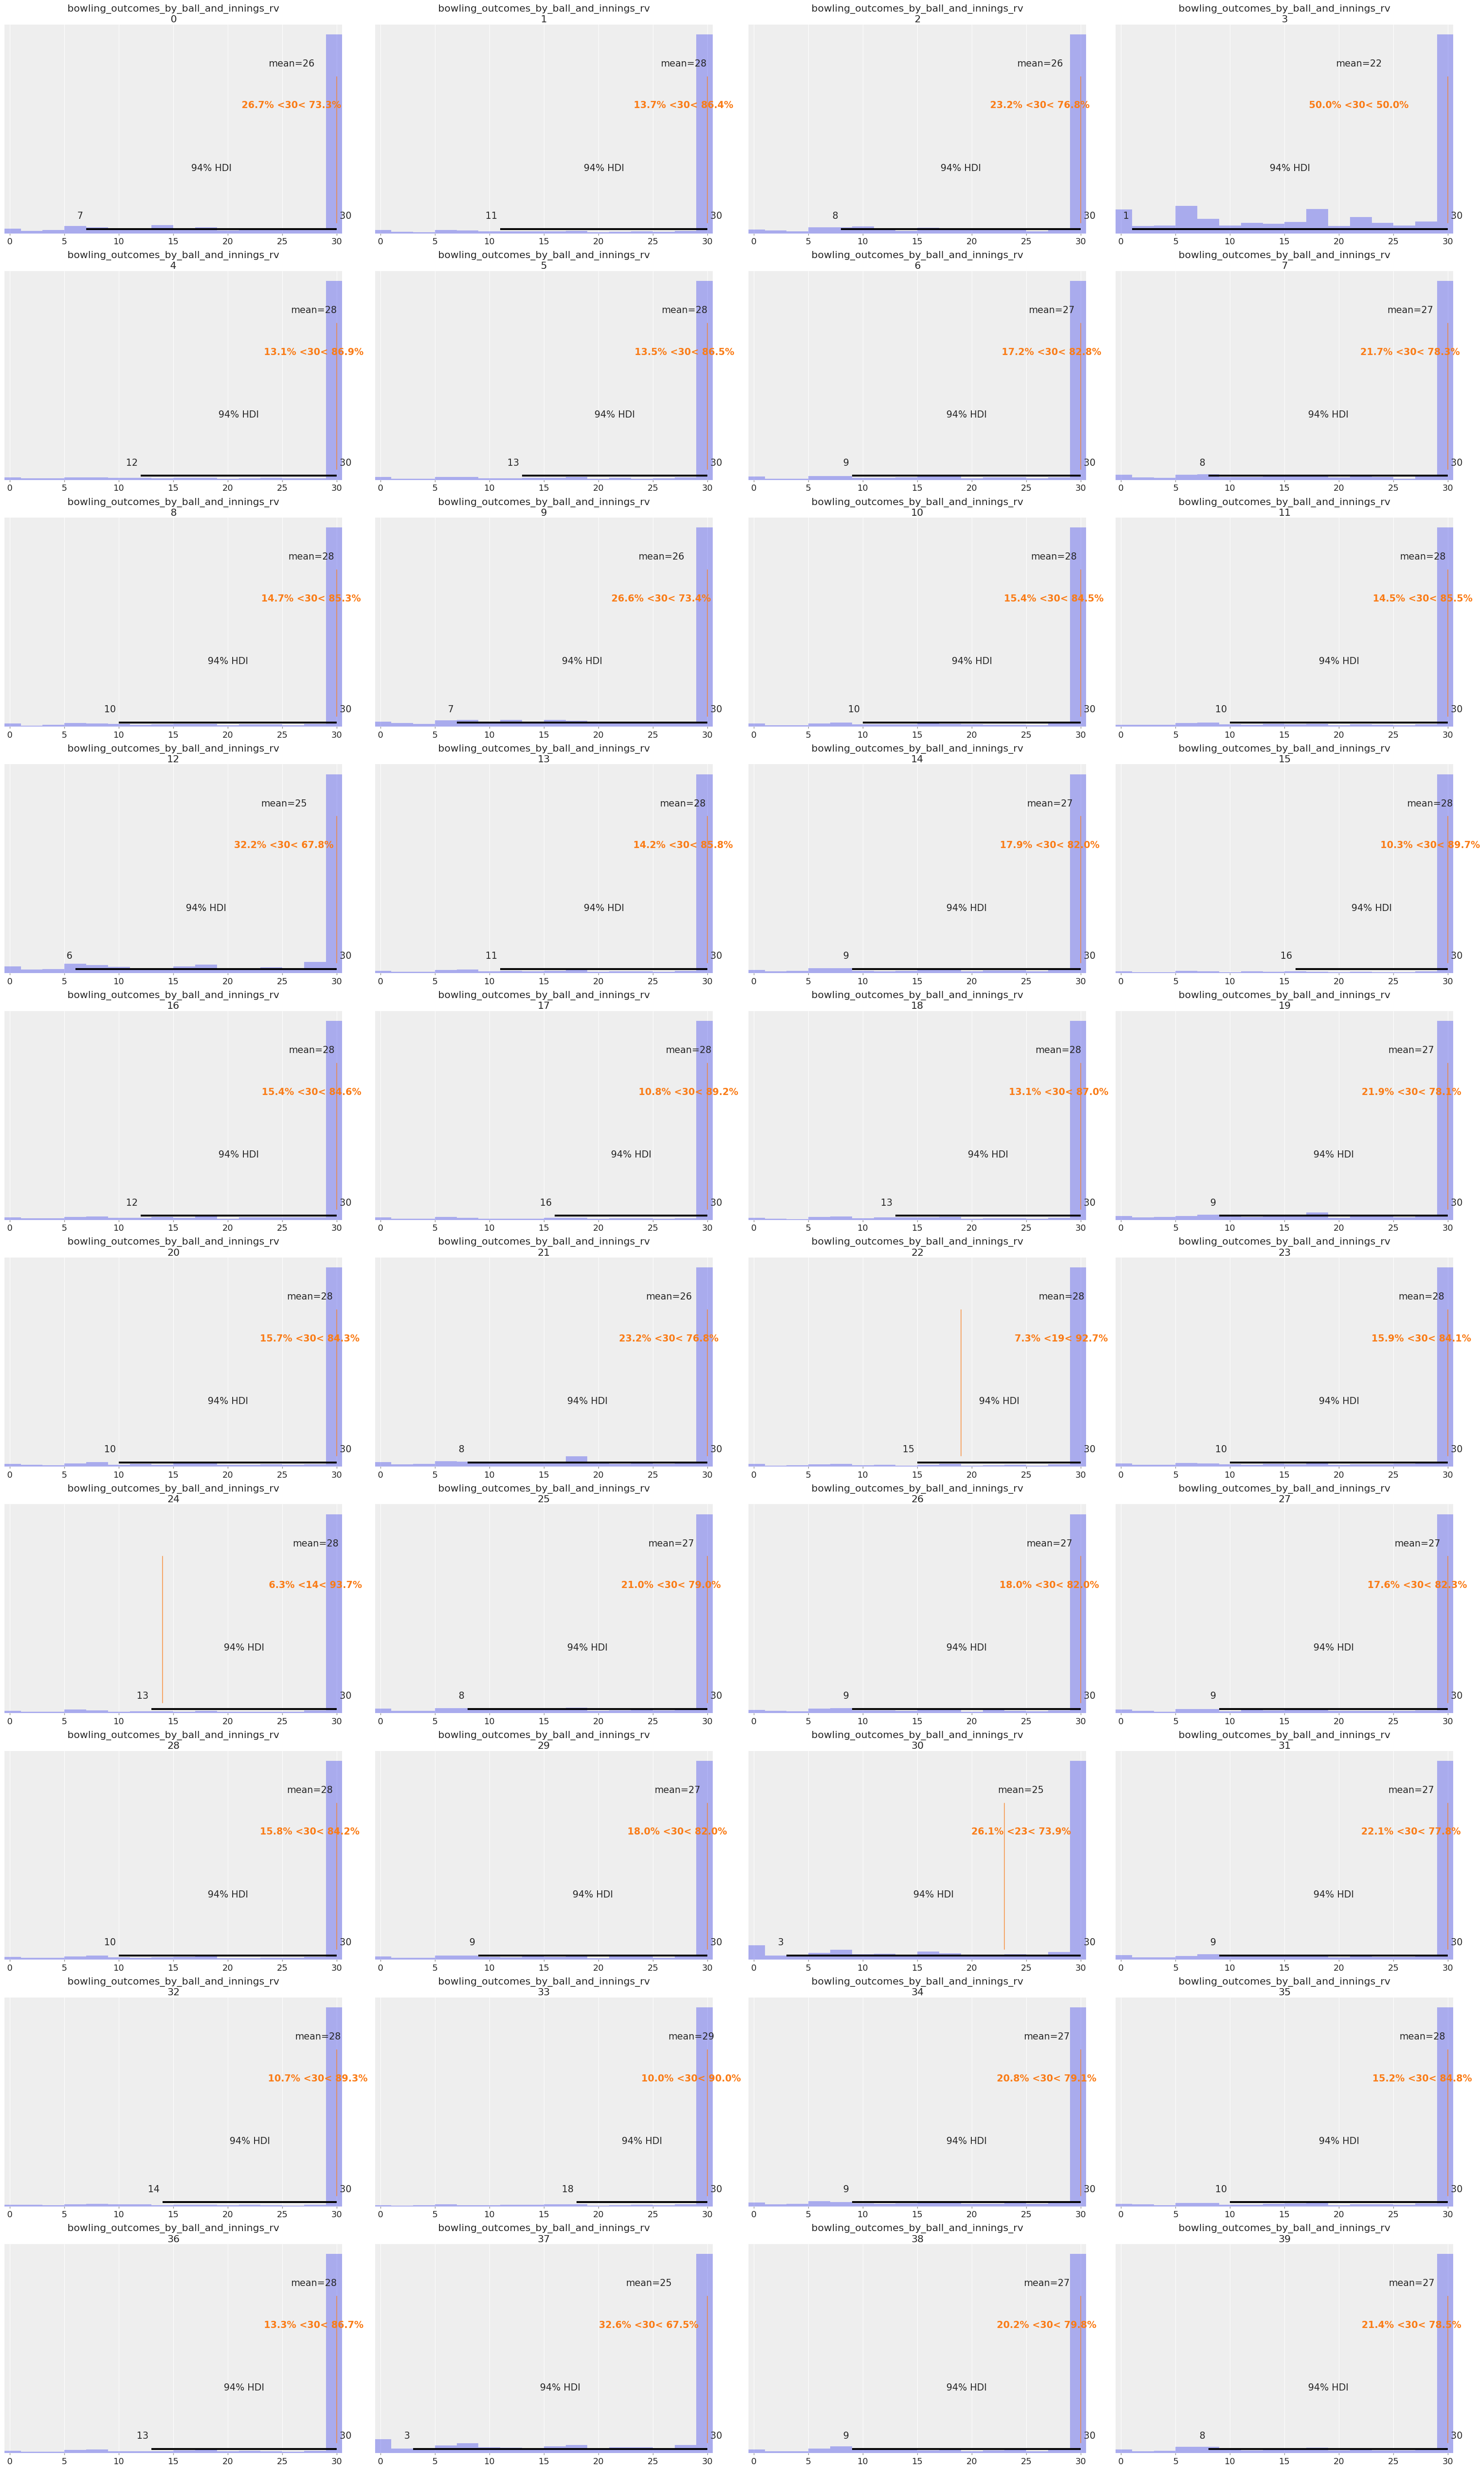

In [183]:
az.plot_posterior(
    inf_data.predictions,
    ref_val=bowling_outcome_rv[train_idx:].tolist()
)